In [2]:
import logging
import numpy as np
from matplotlib import pyplot as plt
import cv2

# Homomorphic filter class
class HomomorphicFilter:
    """Homomorphic filter implemented with diferents filters and an option to an external filter.
    
    High-frequency filters implemented:
        butterworth
        gaussian

    Attributes:
        a, b: Floats used on emphasis filter:
            H = a + b*H
        
        .
    """

    def __init__(self, a = 0.5, b = 1.5):
        self.a = float(a)
        self.b = float(b)

    # Filters
    def __butterworth_filter(self, I_shape, filter_params):
        P = I_shape[0]/2
        Q = I_shape[1]/2
        U, V = np.meshgrid(range(I_shape[0]), range(I_shape[1]), sparse=False, indexing='ij')
        Duv = (((U-P)**2+(V-Q)**2)).astype(float)
        H = 1/(1+(Duv/filter_params[0]**2)**filter_params[1])
        return (1 - H)

    def __gaussian_filter(self, I_shape, filter_params):
        P = I_shape[0]/2
        Q = I_shape[1]/2
        H = np.zeros(I_shape)
        U, V = np.meshgrid(range(I_shape[0]), range(I_shape[1]), sparse=False, indexing='ij')
        Duv = (((U-P)**2+(V-Q)**2)).astype(float)
        H = np.exp((-Duv/(2*(filter_params[0])**2)))
        return (1 - H)

    # Methods
    def __apply_filter(self, I, H):
        H = np.fft.fftshift(H)
        I_filtered = (self.a + self.b*H)*I
        return I_filtered

    def filter(self, I, filter_params, filter='butterworth', H = None):
        """
        Method to apply homormophic filter on an image

        Attributes:
            I: Single channel image
            filter_params: Parameters to be used on filters:
                butterworth:
                    filter_params[0]: Cutoff frequency 
                    filter_params[1]: Order of filter
                gaussian:
                    filter_params[0]: Cutoff frequency
            filter: Choose of the filter, options:
                butterworth
                gaussian
                external
            H: Used to pass external filter
        """

        #  Validating image
        if len(I.shape) is not 2:
            raise Exception('Improper image')

        # Take the image to log domain and then to frequency domain 
        I_log = np.log1p(np.array(I, dtype="float"))
        I_fft = np.fft.fft2(I_log)

        # Filters
        if filter=='butterworth':
            H = self.__butterworth_filter(I_shape = I_fft.shape, filter_params = filter_params)
        elif filter=='gaussian':
            H = self.__gaussian_filter(I_shape = I_fft.shape, filter_params = filter_params)
        elif filter=='external':
            print('external')
            if len(H.shape) is not 2:
                raise Exception('Invalid external filter')
        else:
            raise Exception('Selected filter not implemented')
        
        # Apply filter on frequency domain then take the image back to spatial domain
        I_fft_filt = self.__apply_filter(I = I_fft, H = H)
        I_filt = np.fft.ifft2(I_fft_filt)
        I = np.exp(np.real(I_filt))-1
        return np.uint8(I)
# End of class HomomorphicFilter


In [ ]:
# Code parameters

img_path = '/media/xingbo/Storage/fish_identification/data/SESSION_AQUARIUM/SESSION2/113/fish_2_113_01.png'


    # Main code
img = cv2.imread(img_path)[:, :, 0]
homo_filter = HomomorphicFilter(a = 0.75, b = 1.25)
img_filtered = homo_filter.filter(I=img, filter_params=[30,2])
plt.imshow(img_filtered)


stop at: 55


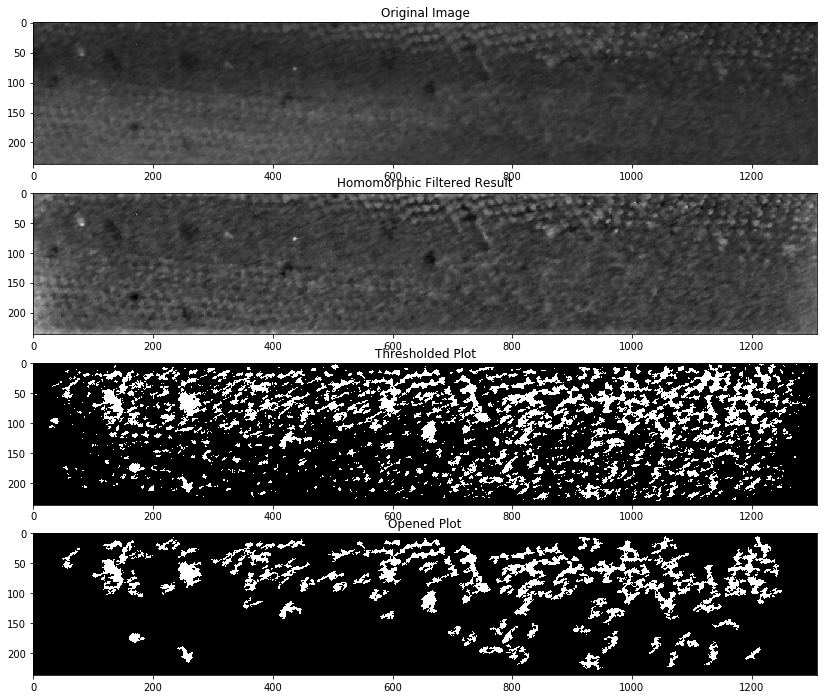

True

In [8]:
import cv2 # For OpenCV modules (For Image I/O and Contour Finding)
import numpy as np # For general purpose array manipulation
import scipy.fftpack # For FFT2
import sys

#### imclearborder definition

def imclearborder(imgBW, radius):

    # Given a black and white image, first find all of its contours
    imgBWcopy = imgBW.copy()
    contours,hierarchy = cv2.findContours(imgBWcopy.copy(), cv2.RETR_LIST,
        cv2.CHAIN_APPROX_SIMPLE)

    # Get dimensions of image
    imgRows = imgBW.shape[0]
    imgCols = imgBW.shape[1]

    contourList = [] # ID list of contours that touch the border

    # For each contour...
    for idx in np.arange(len(contours)):
        # Get the i'th contour
        cnt = contours[idx]

        # Look at each point in the contour
        for pt in cnt:
            rowCnt = pt[0][1]
            colCnt = pt[0][0]

            # If this is within the radius of the border
            # this contour goes bye bye!
            check1 = (rowCnt >= 0 and rowCnt < radius) or (rowCnt >= imgRows-1-radius and rowCnt < imgRows)
            check2 = (colCnt >= 0 and colCnt < radius) or (colCnt >= imgCols-1-radius and colCnt < imgCols)

            if check1 or check2:
                contourList.append(idx)
                break

    for idx in contourList:
        cv2.drawContours(imgBWcopy, contours, idx, (0,0,0), -1)

    return imgBWcopy

#### bwareaopen definition
def bwareaopen(imgBW, areaPixels):
    # Given a black and white image, first find all of its contours
    imgBWcopy = imgBW.copy()
    contours,hierarchy = cv2.findContours(imgBWcopy.copy(), cv2.RETR_LIST,
        cv2.CHAIN_APPROX_SIMPLE)

    # For each contour, determine its total occupying area
    for idx in np.arange(len(contours)):
        area = cv2.contourArea(contours[idx])
        if (area >= 0 and area <= areaPixels):
            cv2.drawContours(imgBWcopy, contours, idx, (0,0,0), -1)

    return imgBWcopy

def binaryiterative(Ihmf2):
    i = 70
    Ithresh = Ihmf2 < i
    while i > 10:
        #print(i)
        Ithresh = Ihmf2 < i
        rate1=np.count_nonzero(Ithresh)/(Ithresh.shape[0]*Ithresh.shape[1]) # should be better smaller than 0.2
        if rate1 <= .2:
            print('stop at:', i)
            break
        i -= 5
        
    return Ithresh

def transform2pigment(img_path):
    # Read in image
    #img = cv2.imread(img_path,0)
    img = cv2.imread(img_path)
    # 读取图像
    r, g, b = cv2.split(img)
    r_avg = cv2.mean(r)[0]
    g_avg = cv2.mean(g)[0]
    b_avg = cv2.mean(b)[0]

    # 求各个通道所占增益
    k = (r_avg + g_avg + b_avg) / 3
    kr = k / r_avg
    kg = k / g_avg
    kb = k / b_avg

    r = cv2.addWeighted(src1=r, alpha=kr, src2=0, beta=0, gamma=0)
    g = cv2.addWeighted(src1=g, alpha=kg, src2=0, beta=0, gamma=0)
    b = cv2.addWeighted(src1=b, alpha=kb, src2=0, beta=0, gamma=0)
    #img = cv2.merge([b, g, r])
    img=b
    # Number of rows and columns
    rows = img.shape[0]
    cols = img.shape[1]

    # Remove some columns from the beginning and end
    img = img[:, 59:cols - 20]

    # Number of rows and columns
    rows = img.shape[0]
    cols = img.shape[1]

    # Convert image to 0 to 1, then do log(1 + I)
    imgLog = np.log1p(np.array(img, dtype="float") / 255)

    # Create Gaussian mask of sigma = 10
    M = 2 * rows + 1
    N = 2 * cols + 1
    sigma = 10
    (X, Y) = np.meshgrid(np.linspace(0, N - 1, N), np.linspace(0, M - 1, M))
    centerX = np.ceil(N / 2)
    centerY = np.ceil(M / 2)
    gaussianNumerator = (X - centerX) ** 2 + (Y - centerY) ** 2

    # Low pass and high pass filters
    Hlow = np.exp(-gaussianNumerator / (2 * sigma * sigma))
    Hhigh = 1 - Hlow

    # Move origin of filters so that it's at the top left corner to
    # match with the input image
    HlowShift = scipy.fftpack.ifftshift(Hlow.copy())
    HhighShift = scipy.fftpack.ifftshift(Hhigh.copy())

    # Filter the image and crop
    If = scipy.fftpack.fft2(imgLog.copy(), (M, N))
    Ioutlow = scipy.real(scipy.fftpack.ifft2(If.copy() * HlowShift, (M, N)))
    Iouthigh = scipy.real(scipy.fftpack.ifft2(If.copy() * HhighShift, (M, N)))

    # Set scaling factors and add
    gamma1 = 0.3
    gamma2 = 1.5
    Iout = gamma1 * Ioutlow[0:rows, 0:cols] + gamma2 * Iouthigh[0:rows, 0:cols]

    # Anti-log then rescale to [0,1]
    Ihmf = np.expm1(Iout)
    Ihmf = (Ihmf - np.min(Ihmf)) / (np.max(Ihmf) - np.min(Ihmf))
    Ihmf2 = np.array(255 * Ihmf, dtype="uint8")

    # Threshold the image - Anything below intensity 65 gets set to white
    Ithresh = binaryiterative(Ihmf2)
    #Ithresh = Ihmf2 < 45
    
    #Ithresh = cv2.adaptiveThreshold(Ihmf2,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,33,0.5)
    Ithresh = 255 * Ithresh.astype("uint8")

    # Clear off the border.  Choose a border radius of 5 pixels
    Iclear = imclearborder(Ithresh, 5)

    # Eliminate regions that have areas below 120 pixels
    Iopen = bwareaopen(Iclear, 120)
    return img,Ihmf2,Ithresh,Iopen
#### Main program
#img_path = '/media/xingbo/Storage/fish_identification/data/SESSION_AQUARIUM/SESSION1/113/fish_2_113_01.png'
img_path = '/media/xingbo/Storage/fish_identification/data/SESSION_AQUARIUM/SESSION1/113/fish_2_113_05.png'

img,Ihmf2,Ithresh,Iopen =transform2pigment(img_path)
# Show all images
fig = plt.figure(figsize=(24,12))
ax1 = fig.add_subplot(411)
ax1.title.set_text('Original Image')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
ax2 = fig.add_subplot(412)
ax2.title.set_text('Homomorphic Filtered Result')
imgIhmf2 = cv2.cvtColor(Ihmf2, cv2.COLOR_BGR2RGB)
plt.imshow(imgIhmf2)
ax3 = fig.add_subplot(413)
ax3.title.set_text('Thresholded Plot')
imgIthresh = cv2.cvtColor(Ithresh, cv2.COLOR_BGR2RGB)
plt.imshow(imgIthresh)
ax4 = fig.add_subplot(414)
ax4.title.set_text('Opened Plot')
imgIopen = cv2.cvtColor(Iopen, cv2.COLOR_BGR2RGB)
plt.imshow(imgIopen)
plt.show()

cv2.imwrite('/media/xingbo/Storage/fish_identification/data/Homomorphic.png',Ihmf2)
cv2.imwrite('/media/xingbo/Storage/fish_identification/data/Thresholded.png',Ithresh)
cv2.imwrite('/media/xingbo/Storage/fish_identification/data/Opened.png',Iopen)

#cv2.imshow('Original Image', img)
#cv2.imshow('Homomorphic Filtered Result', Ihmf2)
#cv2.imshow('Thresholded Result', Ithresh)
#cv2.imshow('Opened Result', Iopen)
#cv2.waitKey(0)
#cv2.destroyAllWindows()

stop at: 55


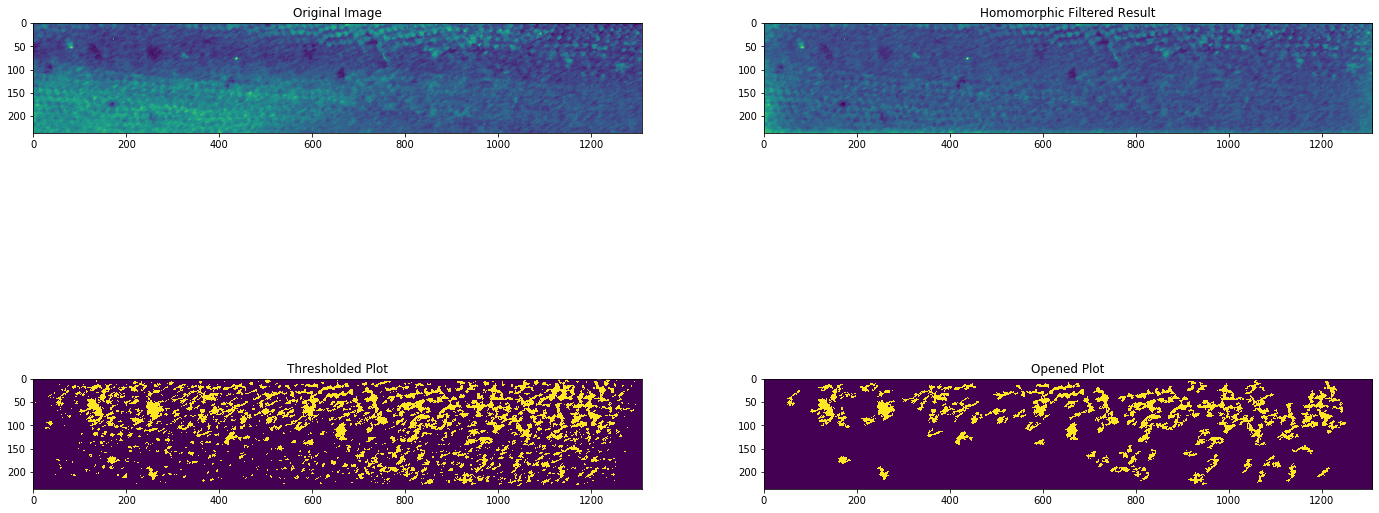

In [5]:
#img_path = '/media/xingbo/Storage/fish_identification/data/SESSION_AQUARIUM/SESSION1/113/fish_2_113_01.png'
img_path = '/media/xingbo/Storage/fish_identification/data/SESSION_AQUARIUM/SESSION1/113/fish_2_113_05.png'
img,Ihmf2,Ithresh,Iopen =transform2pigment(img_path)

# Show all images
fig = plt.figure(figsize=(24,12))
ax1 = fig.add_subplot(221)
ax1.title.set_text('Original Image')
plt.imshow(img)
ax2 = fig.add_subplot(222)
ax2.title.set_text('Homomorphic Filtered Result')
plt.imshow(Ihmf2)
ax3 = fig.add_subplot(223)
ax3.title.set_text('Thresholded Plot')
plt.imshow(Ithresh)
ax4 = fig.add_subplot(224)
ax4.title.set_text('Opened Plot')
plt.imshow(Iopen)
plt.show()

In [ ]:

img_path = '/media/xingbo/Storage/fish_identification/data/SESSION_AQUARIUM/SESSION1/100/fish_2_100_01.png'

import cv2 as cv
# import numpy as np
 
# 读取图像
img = cv.imread(img_path)
r, g, b = cv.split(img)
r_avg = cv.mean(r)[0]
g_avg = cv.mean(g)[0]
b_avg = cv.mean(b)[0]
 
# 求各个通道所占增益
k = (r_avg + g_avg + b_avg) / 3
kr = k / r_avg
kg = k / g_avg
kb = k / b_avg
 
r = cv.addWeighted(src1=r, alpha=kr, src2=0, beta=0, gamma=0)
g = cv.addWeighted(src1=g, alpha=kg, src2=0, beta=0, gamma=0)
b = cv.addWeighted(src1=b, alpha=kb, src2=0, beta=0, gamma=0)
balance_img = cv.merge([b, g, r])
cv2.imwrite('/media/xingbo/Storage/fish_identification/data/balance_img2.png',balance_img)


In [ ]:

# Show all images
fig = plt.figure(figsize=(120,60))
ax1 = fig.add_subplot(221)
ax1.title.set_text('Original Image')
plt.imshow(img)
ax2 = fig.add_subplot(222)
ax2.title.set_text('Homomorphic Filtered Result')
plt.imshow(Ihmf2)
ax3 = fig.add_subplot(223)
ax3.title.set_text('Thresholded Plot')
plt.imshow(Ithresh)
ax4 = fig.add_subplot(224)
ax4.title.set_text('Opened Plot')
plt.imshow(Iopen)
plt.show()

In [ ]:
img_tmp=Ithresh

contours, hierarchy  = cv2.findContours ( img_tmp , cv2.RETR_EXTERNAL , cv2.CHAIN_APPROX_SIMPLE )
cv2.drawContours(img_tmp,contours,-1,(0,0,255),3) 
cv2.putText(img_tmp, "{:.3f}".format(len ( contours )), (30, 30),cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0,255,0), 1)   

# Show all images
fig = plt.figure(figsize=(120,60))
ax1 = fig.add_subplot(221)
ax1.title.set_text('Original Image')
plt.imshow(Ithresh)
ax2 = fig.add_subplot(222)
ax2.title.set_text('img_tmp')
plt.imshow(img_tmp)

In [ ]:
# find contours in the binary image
im2, contours, hierarchy = cv2.findContours(Ithresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
for c in contours:
   # calculate moments for each contour
   M = cv2.moments(c)
 
   # calculate x,y coordinate of center
   cX = int(M["m10"] / M["m00"])
   cY = int(M["m01"] / M["m00"])
   cv2.circle(Ithresh, (cX, cY), 5, (255, 255, 255), -1)
   cv2.putText(Ithresh, "centroid", (cX - 25, cY - 25),cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
 
   # display the image
plt.imshow(Ithresh)


stop at: 55


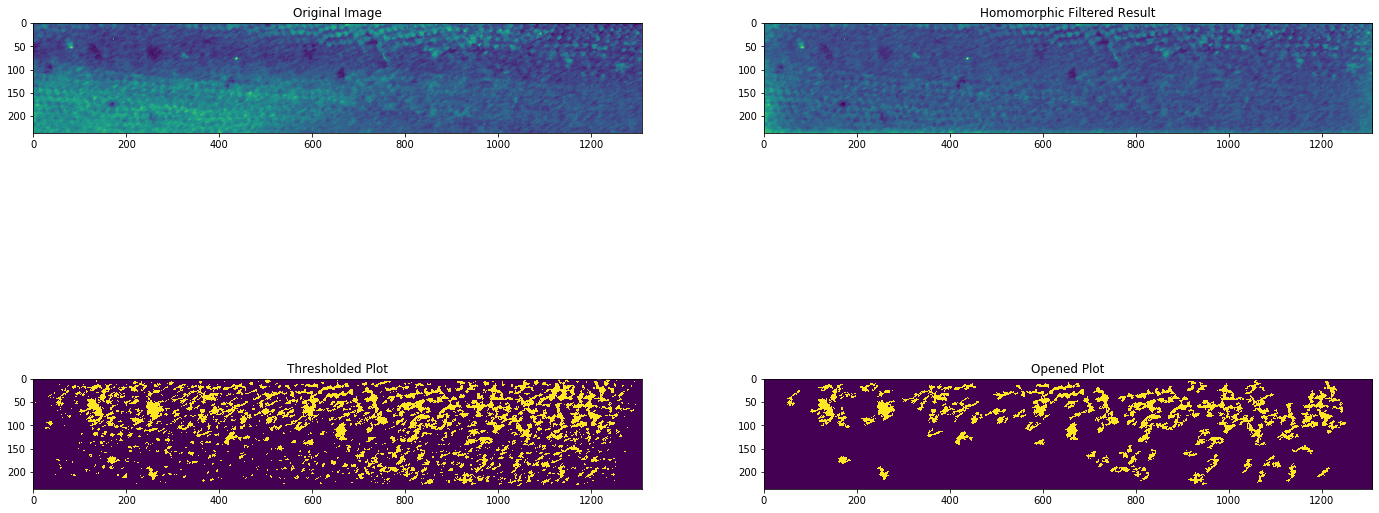

In [3]:
import logging
import numpy as np
from matplotlib import pyplot as plt
import cv2
from pigementUtil import * 

SAVE_PATH ='/media/xingbo/Storage/fish_identification/data/SESSION_AQUARIUM/SESSION_PIGMENT'

mypigementUtil = pigementUtil(SAVE_PATH)

#img_path = '/media/xingbo/Storage/fish_identification/data/SESSION_AQUARIUM/SESSION1/113/fish_2_113_01.png'
img_path = '/media/xingbo/Storage/fish_identification/data/SESSION_AQUARIUM/SESSION1/113/fish_2_113_05.png'
img,Ihmf2,Ithresh,Iopen =mypigementUtil.transform2pigment(img_path)

# Show all images
fig = plt.figure(figsize=(24,12))
ax1 = fig.add_subplot(221)
ax1.title.set_text('Original Image')
plt.imshow(img)
ax2 = fig.add_subplot(222)
ax2.title.set_text('Homomorphic Filtered Result')
plt.imshow(Ihmf2)
ax3 = fig.add_subplot(223)
ax3.title.set_text('Thresholded Plot')
plt.imshow(Ithresh)
ax4 = fig.add_subplot(224)
ax4.title.set_text('Opened Plot')
plt.imshow(Iopen)
plt.show()